In [1]:
# Import libraries
from pyspark.sql import SparkSession
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re

ModuleNotFoundError: No module named 'pyspark'

In [2]:
# Create functions

def getYear(x):
    return int(datetime.strptime(x,'%a %b %d %H:%M:%S +0000 %Y').strftime('%Y'))

def parseDate(x):
    return str(datetime.strptime(x,'%a %b %d %H:%M:%S +0000 %Y').strftime('%Y-%m-%d'))

emoticons_str = r"""
    (?:
    [:=;] # Eyes
    [oO\-]? # Nose (optional)
    [D\)\]\(\]/\\OpP] # Mouth
    )"""
    
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hashtags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
#     r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
stop_words = stopwords.words('english') + list(string.punctuation) + ['rt', 'via', 'amp', '’', '…', '—', '“', '”']

def preprocessText(s):    
    tokens = tokens_re.findall(s)
    tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

In [1]:
# Create spark session
spark = SparkSession \
    .builder \
    .enableHiveSupport() \
    .getOrCreate()

NameError: name 'SparkSession' is not defined

In [4]:
# Read in twitter user party affiliation
twitter_handles = pd.read_csv("twitter_handles_final.csv")

democrats = twitter_handles[twitter_handles.party == 'D']
republicans = twitter_handles[twitter_handles.party == 'R']

In [5]:
# Create rdd from twitter json file
tweetsRDD = spark.sparkContext.textFile("congress115-116-tweets.jsonl").map(json.loads)

# Keep tweets from known users, filter out retweets and tweets earlier than 2017
tweetsRDD = tweetsRDD.filter(lambda tweet: tweet['user']['screen_name'] in twitter_handles['user'].tolist())
# tweetsRDD = tweetsRDD.filter(lambda tweet: 'RT @' not in tweet['full_text'])
tweetsRDD = tweetsRDD.filter(lambda tweet: getYear(tweet['created_at']) >= 2017)

In [6]:
# Count number of user followers
userFollowerCountsRDD = (tweetsRDD
                         .map(lambda tweet: (tweet['user']['screen_name'], tweet['user']['followers_count']))
                         .reduceByKey(max)
                        )

In [8]:
# Convert to dataframe, sort by descending order, and merge party info
columns = ['user', 'followers']
userFollowerCounts = userFollowerCountsRDD.toDF(columns).toPandas()
userFollowerCounts = userFollowerCounts.sort_values('followers', ascending = False)
userFollowerCounts = userFollowerCounts.merge(twitter_handles, how = 'inner', on = 'user')

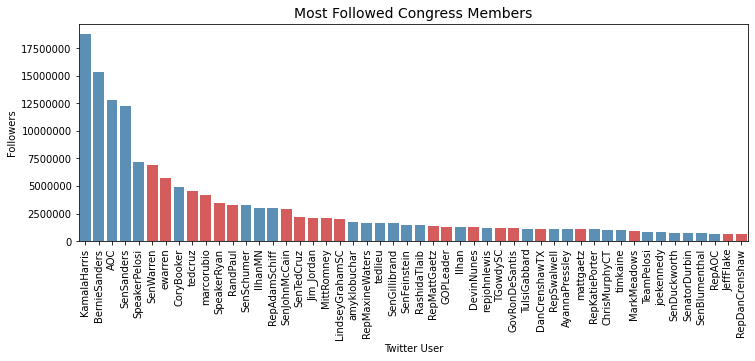

In [9]:
# Plot users with most followers
plt.figure(figsize = (12, 4))
sns.barplot(x = 'user', y = 'followers', data = userFollowerCounts.head(50), 
            hue = 'party', palette = ["#1F78B4", "#E31A1C"], dodge = False, alpha = 0.8)
plt.xlabel('Twitter User')
plt.ylabel('Followers')
plt.xticks(rotation = 90, fontsize = 10)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.title("Most Followed Congress Members", fontsize = 14)
plt.legend([],[], frameon = False)
plt.show()

In [10]:
# Count number of user tweets 
userTweetCountsRDD = (tweetsRDD
                      .map(lambda tweet: (tweet['user']['screen_name'], 1))
                      .reduceByKey(lambda a, b: a + b)
                     )

In [12]:
# Convert to dataframe, sort by descending order, and merge party info
columns = ['user', 'tweets']
userTweetCounts = userTweetCountsRDD.toDF(columns).toPandas()
userTweetCounts = userTweetCounts.sort_values('tweets', ascending = False)
userTweetCounts = userTweetCounts.merge(twitter_handles, how = 'inner', on = 'user')

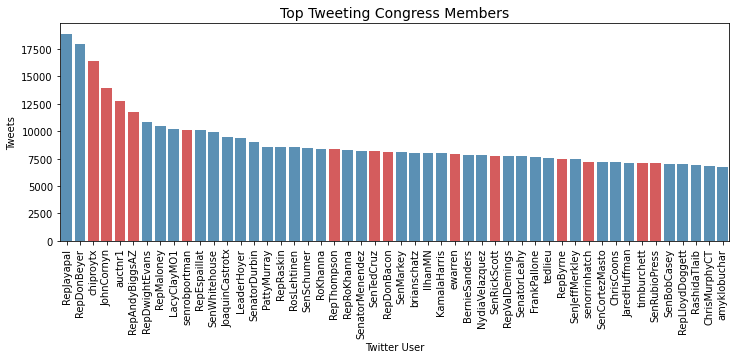

In [13]:
# Plot users with most tweets
plt.figure(figsize = (12, 4))
sns.barplot(x = 'user', y = 'tweets', data = userTweetCounts.head(50),
            hue = 'party', palette = ["#1F78B4", "#E31A1C"], dodge = False, alpha = 0.8)
plt.xlabel('Twitter User')
plt.ylabel('Tweets')
plt.xticks(rotation = 90, fontsize = 10)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.title("Top Tweeting Congress Members", fontsize = 14)
plt.legend([],[], frameon = False)
plt.show()

In [35]:
# Count hashtag usage frequency
hashtagCountsRDD = (tweetsRDD
                    .flatMap(lambda tweet: [hashtag['text'].lower() for hashtag in tweet["entities"]["hashtags"]])
                    .map(lambda hashtag: (hashtag, 1))
                    .reduceByKey(lambda a, b: a + b)
                   )

In [36]:
# Convert to dataframe and sort by descending order
columns = ['hashtag', 'tweets']
hashtagCounts = hashtagCountsRDD.map(lambda kv: (kv[0], kv[1])).toDF(columns).toPandas()
hashtagCounts = hashtagCounts.sort_values('tweets', ascending = False)

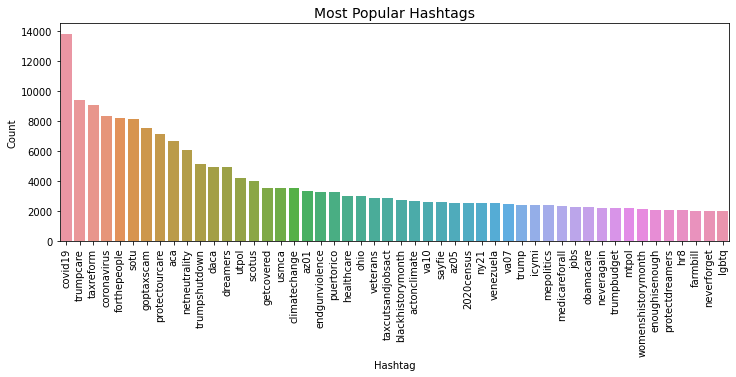

In [37]:
# Plot most popular hashtags
plt.figure(figsize = (12, 4))
sns.barplot(x = 'hashtag', y = 'tweets', data = hashtagCounts.head(50))
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.xticks(rotation = 90, fontsize = 10)
plt.title("Most Popular Hashtags", fontsize = 14)
plt.show()

In [38]:
# Count democrat hashtag usage frequency
hashtagCountsDemRDD = (tweetsRDD
                       .filter(lambda tweet: tweet['user']['screen_name'] in democrats['user'].tolist())
                       .flatMap(lambda tweet: [hashtag['text'].lower() for hashtag in tweet["entities"]["hashtags"]])
                       .map(lambda hashtag: (hashtag, 1))
                       .reduceByKey(lambda a, b: a + b)
                      )

# Count republican hashtag usage frequency
hashtagCountsRepRDD = (tweetsRDD
                       .filter(lambda tweet: tweet['user']['screen_name'] in republicans['user'].tolist())
                       .flatMap(lambda tweet: [hashtag['text'].lower() for hashtag in tweet["entities"]["hashtags"]])
                       .map(lambda hashtag: (hashtag, 1))
                       .reduceByKey(lambda a, b: a + b)
                      )

In [39]:
# Convert to dataframe
columns = ['hashtag', 'dem']
hashtagCountsDem = hashtagCountsDemRDD.map(lambda kv: (kv[0], kv[1])).toDF(columns).toPandas()

# Convert to dataframe
columns = ['hashtag', 'rep']
hashtagCountsRep = hashtagCountsRepRDD.map(lambda kv: (kv[0], kv[1])).toDF(columns).toPandas()

# Merge dataframes and sort by descending order
hashtagCountsDemRep = hashtagCountsDem.merge(hashtagCountsRep, how = 'inner', on = 'hashtag')
hashtagCountsDemRep['tweets'] = hashtagCountsDemRep['dem'] + hashtagCountsDemRep['rep']
hashtagCountsDemRep = hashtagCountsDemRep.sort_values('tweets', ascending = False)

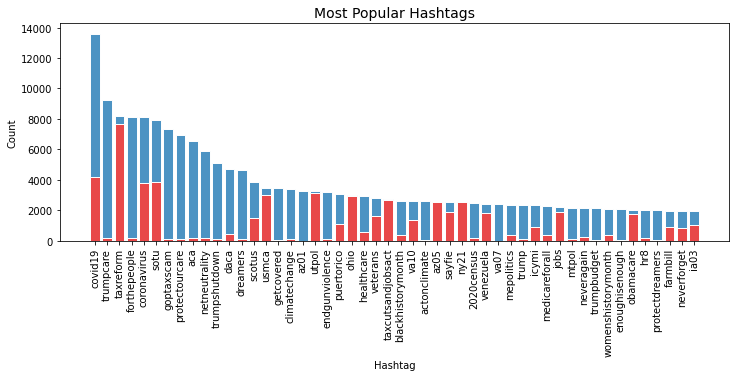

In [40]:
# Plot most popular hashtags
topHashtags = hashtagCountsDemRep.head(50).melt(id_vars = ['hashtag', 'tweets'], value_vars = ['dem', 'rep'])

sns.set_palette(["#1F78B4", "#E31A1C"])
plt.figure(figsize = (12, 4))
sns.histplot(x = 'hashtag', weights = 'value', data = topHashtags,
             multiple = 'stack', edgecolor = 'white', shrink = 0.8,
             hue = 'variable', palette = ["#1F78B4", "#E31A1C"], alpha = 0.8)
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.xticks(rotation = 90, fontsize = 10)
plt.title("Most Popular Hashtags", fontsize = 14)
plt.legend([],[], frameon = False)
plt.show()

In [41]:
# Calculate average number of retweets per user
userAverageRetweetsRDD = (tweetsRDD
                          .map(lambda tweet: (tweet['user']['screen_name'], tweet['retweet_count']))
                          .mapValues(lambda x: (x, 1))
                          .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
                          .mapValues(lambda x: x[0] / x[1])
                         )

In [42]:
# Convert to dataframe and sort by descending order
columns = ['user', 'retweets']
userAverageRetweets = userAverageRetweetsRDD.map(lambda kv: (kv[0], kv[1])).toDF(columns).toPandas()
userAverageRetweets = userAverageRetweets.sort_values('retweets', ascending = False)
userAverageRetweets = userAverageRetweets.merge(partyAffiliation, how = 'inner', on = 'user')

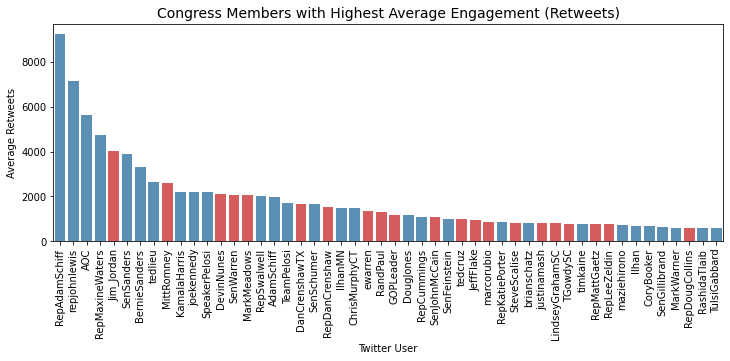

In [43]:
# Plot users with highest average engagement
plt.figure(figsize = (12, 4))
sns.barplot(x = 'user', y = 'retweets', data = userAverageRetweets.head(50),
            hue = 'party', palette = ["#1F78B4", "#E31A1C"], dodge = False, alpha = 0.8)
plt.xlabel('Twitter User')
plt.ylabel('Average Retweets')
plt.xticks(rotation = 90, fontsize = 10)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.title("Congress Members with Highest Average Engagement (Retweets)", fontsize = 14)
plt.legend([],[], frameon = False)
plt.show()

In [44]:
# Count number of tweets by date
dateTweetCountsRDD = (tweetsRDD
                      .map(lambda tweet: (parseDate(tweet['created_at']), 1))
                      .reduceByKey(lambda a, b: a + b)
                     )

In [45]:
# Convert to dataframe and sort by descending order
columns = ['date', 'tweets']
dateTweetCounts = dateTweetCountsRDD.map(lambda kv: (kv[0], kv[1])).toDF(columns).toPandas()
dateTweetCounts = dateTweetCounts.sort_values('tweets', ascending = False)
# dateTweetCounts.head(10)

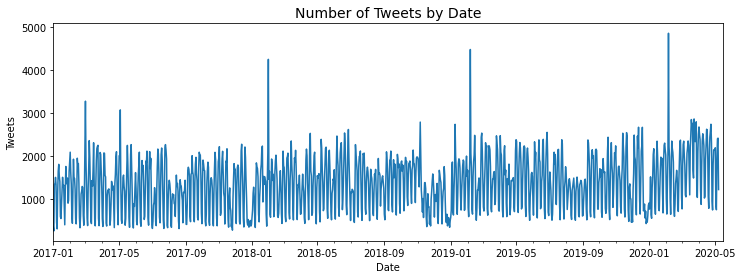

In [46]:
# Plot number of tweets by date
dateTweetCounts.date = pd.to_datetime(dateTweetCounts.date, format = '%Y-%m-%d')

fig, ax = plt.subplots(figsize = (12, 4))
sns.lineplot(x = 'date', y = 'tweets', data = dateTweetCounts)
plt.xlabel('Date')
plt.ylabel('Tweets')
plt.xlim(pd.to_datetime(['2017-01-01','2020-05-15'], format = '%Y-%m-%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval = 1))
plt.title("Number of Tweets by Date", fontsize = 14)
plt.show()

In [60]:
# Count number of retweets by date and user (take average retweet count per user on given date)
dateRetweetCountsRDD = (tweetsRDD
                        .map(lambda tweet: ((parseDate(tweet['created_at']), tweet['user']['screen_name']), tweet['retweet_count']))
                        .mapValues(lambda x: (x, 1))
                        .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
                        .mapValues(lambda x: x[0] / x[1])
                       )

In [61]:
# Convert to dataframe and sort by descending order
columns = ['date','user', 'retweets']
dateRetweetCounts = dateRetweetCountsRDD.map(lambda kv: (kv[0][0], kv[0][1], kv[1])).toDF(columns).toPandas()
dateRetweetCounts = dateRetweetCounts.sort_values('retweets', ascending = False)

In [62]:
# Calculate median retweets by date
dateMedianRetweets = dateRetweetCounts.groupby('date').median().reset_index()
dateMedianRetweets = dateMedianRetweets.sort_values('retweets', ascending = False)
# dateMedianRetweets.to_csv("median_retweets_by_date.csv", header = True)
# dateMedianRetweets.head(10)

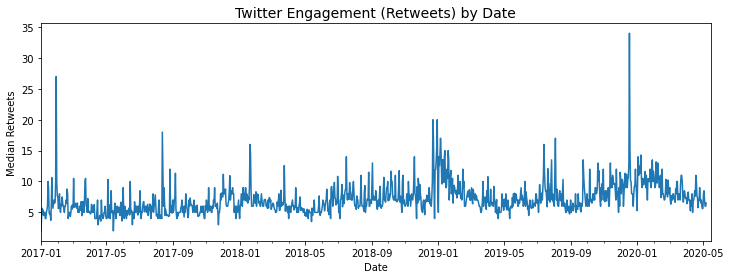

In [63]:
# Plot median retweets by date
dateMedianRetweets['date'] = pd.to_datetime(dateMedianRetweets['date'], format = '%Y-%m-%d')

fig, ax = plt.subplots(figsize = (12, 4))
sns.lineplot(x = 'date', y = 'retweets', data = dateMedianRetweets)
plt.xlabel('Date')
plt.ylabel('Median Retweets')
plt.xlim(pd.to_datetime(['2017-01-01','2020-05-15'], format = '%Y-%m-%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval = 1))
plt.title("Twitter Engagement (Retweets) by Date", fontsize = 14)
plt.show()

In [89]:
# Count number of democrat retweets by date and user (take average retweet count per user on given date)
dateRetweetCountsDemRDD = (tweetsRDD
                           .filter(lambda tweet: tweet['user']['screen_name'] in democrats['user'].tolist())
                           .map(lambda tweet: ((parseDate(tweet['created_at']), tweet['user']['screen_name']), tweet['retweet_count']))
                           .mapValues(lambda x: (x, 1))
                           .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
                           .mapValues(lambda x: x[0] / x[1])
                          )

# Count number of republican retweets by date and user (take average retweet count per user on given date)
dateRetweetCountsRepRDD = (tweetsRDD
                           .filter(lambda tweet: tweet['user']['screen_name'] in republicans['user'].tolist())
                           .map(lambda tweet: ((parseDate(tweet['created_at']), tweet['user']['screen_name']), tweet['retweet_count']))
                           .mapValues(lambda x: (x, 1))
                           .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
                           .mapValues(lambda x: x[0] / x[1])
                          )

In [90]:
# Convert to dataframe and sort by descending order
columns = ['date','user', 'retweets']
dateRetweetCountsDem = dateRetweetCountsDemRDD.map(lambda kv: (kv[0][0], kv[0][1], kv[1])).toDF(columns).toPandas()
dateRetweetCountsDem = dateRetweetCountsDem.sort_values('retweets', ascending = False)

# Convert to dataframe and sort by descending order
columns = ['date','user', 'retweets']
dateRetweetCountsRep = dateRetweetCountsRepRDD.map(lambda kv: (kv[0][0], kv[0][1], kv[1])).toDF(columns).toPandas()
dateRetweetCountsRep = dateRetweetCountsRep.sort_values('retweets', ascending = False)

In [91]:
# Calculate median democrat retweets by date
dateMedianRetweetsDem = dateRetweetCountsDem.groupby('date').median().reset_index()
dateMedianRetweetsDem = dateMedianRetweetsDem.sort_values('retweets', ascending = False)
# dateMedianRetweetsDem.to_csv("median_democrat_retweets_by_date.csv", header = True)

# Calculate median republican retweets by date
dateMedianRetweetsRep = dateRetweetCountsRep.groupby('date').median().reset_index()
dateMedianRetweetsRep = dateMedianRetweetsRep.sort_values('retweets', ascending = False)
# dateMedianRetweetsRep.to_csv("median_republican_retweets_by_date.csv", header = True)

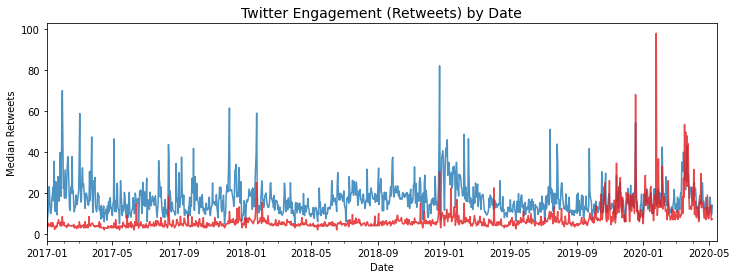

In [92]:
# Plot median democrat and republican retweets by date
dateMedianRetweetsDem['party'], dateMedianRetweetsRep['party'] = 'D', 'R'
dateMedianRetweetsDemRep = dateMedianRetweetsDem.append(dateMedianRetweetsRep)
dateMedianRetweetsDemRep['date'] = pd.to_datetime(dateMedianRetweetsDemRep['date'], format = '%Y-%m-%d')

fig, ax = plt.subplots(figsize = (12, 4))
sns.set_palette(["#1F78B4", "#E31A1C"])
sns.lineplot(x = 'date', y = 'retweets', data = dateMedianRetweetsDemRep, 
             hue = 'party', palette = ["#1F78B4", "#E31A1C"], alpha = 0.8)
plt.xlabel('Date')
plt.ylabel('Median Retweets')
plt.xlim(pd.to_datetime(['2017-01-01','2020-05-15'], format = '%Y-%m-%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval = 1))
plt.title("Twitter Engagement (Retweets) by Date", fontsize = 14)
plt.legend([],[], frameon = False)
plt.show()

In [68]:
# Count number of favorites by date and user (take average favorite count per user on given date)
dateFavoriteCountsRDD = (tweetsRDD
                         .map(lambda tweet: ((parseDate(tweet['created_at']), tweet['user']['screen_name']), tweet['favorite_count']))
                         .mapValues(lambda x: (x, 1))
                         .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
                         .mapValues(lambda x: x[0] / x[1])
                        )

In [69]:
# Convert to dataframe and sort by descending order
columns = ['date','user', 'favorites']
dateFavoriteCounts = dateFavoriteCountsRDD.map(lambda kv: (kv[0][0], kv[0][1], kv[1])).toDF(columns).toPandas()
dateFavoriteCounts = dateFavoriteCounts.sort_values('favorites', ascending = False)

In [70]:
# Calculate median favorites by date
dateMedianFavorites = dateFavoriteCounts.groupby('date').median().reset_index()
dateMedianFavorites = dateMedianFavorites.sort_values('favorites', ascending = False)
# dateMedianFavorites.to_csv("median_favorites_by_date.csv", header = True)
# dateMedianFavorites.head(10)

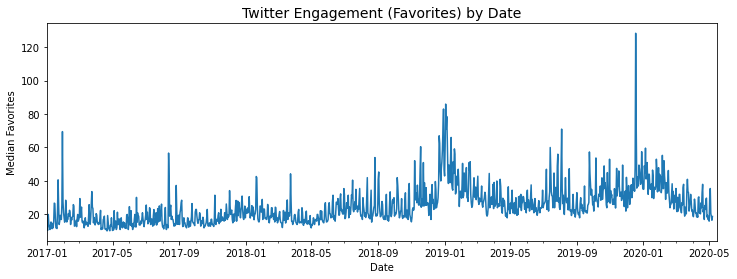

In [71]:
# Plot median favorites by date
dateMedianFavorites['date'] = pd.to_datetime(dateMedianFavorites['date'], format = '%Y-%m-%d')

fig, ax = plt.subplots(figsize = (12, 4))
sns.lineplot(x = 'date', y = 'favorites', data = dateMedianFavorites)
plt.xlabel('Date')
plt.ylabel('Median Favorites')
plt.xlim(pd.to_datetime(['2017-01-01','2020-05-15'], format = '%Y-%m-%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval = 1))
plt.title("Twitter Engagement (Favorites) by Date", fontsize = 14)
plt.show()

In [72]:
# Count number of democrat retweets by date and user (take average favorite count per user on given date)
dateFavoriteCountsDemRDD = (tweetsRDD
                            .filter(lambda tweet: tweet['user']['screen_name'] in democrats['user'].tolist())
                            .map(lambda tweet: ((parseDate(tweet['created_at']),
                                                 tweet['user']['screen_name']),
                                                tweet['favorite_count']))
                            .mapValues(lambda x: (x, 1))
                            .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
                            .mapValues(lambda x: x[0] / x[1])
                           )

# Count number of republican retweets by date and user (take average favorite count per user on given date)
dateFavoriteCountsRepRDD = (tweetsRDD
                            .filter(lambda tweet: tweet['user']['screen_name'] in republicans['user'].tolist())
                            .map(lambda tweet: ((parseDate(tweet['created_at']),
                                                 tweet['user']['screen_name']),
                                                tweet['favorite_count']))
                            .mapValues(lambda x: (x, 1))
                            .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
                            .mapValues(lambda x: x[0] / x[1])
                           )

In [73]:
# Convert to dataframe and sort by descending order
columns = ['date','user', 'favorites']
dateFavoriteCountsDem = dateFavoriteCountsDemRDD.map(lambda kv: (kv[0][0], kv[0][1], kv[1])).toDF(columns).toPandas()
dateFavoriteCountsDem = dateFavoriteCountsDem.sort_values('favorites', ascending = False)

# Convert to dataframe and sort by descending order
columns = ['date','user', 'favorites']
dateFavoriteCountsRep = dateFavoriteCountsRepRDD.map(lambda kv: (kv[0][0], kv[0][1], kv[1])).toDF(columns).toPandas()
dateFavoriteCountsRep = dateFavoriteCountsRep.sort_values('favorites', ascending = False)

In [74]:
# Calculate median democrat favorites by date
dateMedianFavoritesDem = dateFavoriteCountsDem.groupby('date').median().reset_index()
dateMedianFavoritesDem = dateMedianFavoritesDem.sort_values('favorites', ascending = False)
# dateMedianFavoritesDem.to_csv("median_democrat_favorites_by_date.csv", header = True)

# Calculate median republican favorites by date
dateMedianFavoritesRep = dateFavoriteCountsRep.groupby('date').median().reset_index()
dateMedianFavoritesRep = dateMedianFavoritesRep.sort_values('favorites', ascending = False)
# dateMedianFavoritesRep.to_csv("median_republican_favorites_by_date.csv", header = True)

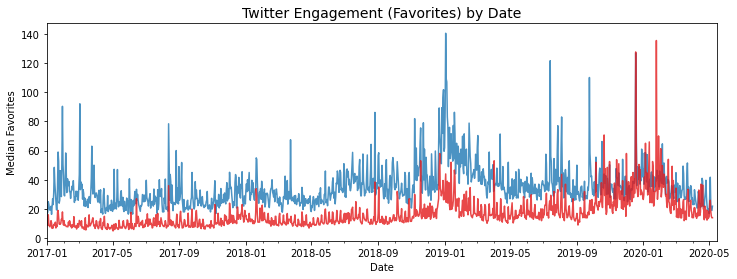

In [75]:
# Plot median democrat and republican favorites by date
dateMedianFavoritesDem['party'], dateMedianFavoritesRep['party'] = 'D', 'R'
dateMedianFavoritesDemRep = dateMedianFavoritesDem.append(dateMedianFavoritesRep)
dateMedianFavoritesDemRep['date'] = pd.to_datetime(dateMedianFavoritesDemRep['date'], format = '%Y-%m-%d')

fig, ax = plt.subplots(figsize = (12, 4))
sns.set_palette(["#1F78B4", "#E31A1C"])
sns.lineplot(x = 'date', y = 'favorites', data = dateMedianFavoritesDemRep, 
             hue = 'party', palette = ["#1F78B4", "#E31A1C"], alpha = 0.8)
plt.xlabel('Date')
plt.ylabel('Median Favorites')
plt.xlim(pd.to_datetime(['2017-01-01','2020-05-15'], format = '%Y-%m-%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval = 1))
plt.title("Twitter Engagement (Favorites) by Date", fontsize = 14)
plt.legend([],[], frameon = False)
plt.show()

In [76]:
# Count bigram frequency
wordCountsRDD = (tweetsRDD
                 .flatMap(lambda tweet: [word for word in nltk.bigrams(preprocessText(tweet['full_text']))])
                 .map(lambda word: (word, 1))
                 .reduceByKey(lambda a, b: a + b)
                )

# Return most frequent bigrams
wordCountsRDD.takeOrdered(100, lambda kv: -kv[1])

[(('health', 'care'), 41553),
 (('president', 'trump'), 21851),
 (('american', 'people'), 20877),
 (('make', 'sure'), 16412),
 (('trump', 'administration'), 14611),
 (('united', 'states'), 14055),
 (('small', 'businesses'), 13712),
 (('gun', 'violence'), 13410),
 (('across', 'country'), 13141),
 (('town', 'hall'), 13005),
 (('every', 'day'), 12731),
 (('look', 'forward'), 12645),
 (('men', 'women'), 12478),
 (('climate', 'change'), 11660),
 (('last', 'night'), 11247),
 (('last', 'week'), 10849),
 (('years', 'ago'), 10474),
 (('national', 'security'), 10412),
 (('looking', 'forward'), 10337),
 (('⬇', '️'), 10199),
 (('🇺', '🇸'), 9579),
 (('law', 'enforcement'), 9500),
 (('white', 'house'), 9293),
 (('high', 'school'), 9011),
 (('public', 'health'), 8428),
 (('covid', '19'), 8044),
 (("i'm", 'proud'), 7725),
 (('first', 'responders'), 7688),
 (('➡', '️'), 7612),
 (('tax', 'cuts'), 7470),
 (('happy', 'birthday'), 7402),
 (('social', 'security'), 7333),
 (('pre-existing', 'conditions'), 711

In [77]:
# Count bigram frequency from date
wordCountsRDD = (tweetsRDD
                 .filter(lambda tweet: parseDate(tweet['created_at']) == '2017-08-12')
                 .flatMap(lambda tweet: [word for word in nltk.bigrams(preprocessText(tweet['full_text']))])
                 .map(lambda word: (word, 1))
                 .reduceByKey(lambda a, b: a + b)
                )

# Return most used words
wordCountsRDD.takeOrdered(100, lambda kv: -kv[1])

[(('must', 'stand'), 32),
 (('white', 'supremacists'), 29),
 (('must', 'condemn'), 25),
 (('violence', '#charlottesville'), 22),
 (('hate', 'bigotry'), 21),
 (('white', 'supremacy'), 20),
 (('racism', 'hatred'), 17),
 (('hate', 'violence'), 17),
 (('place', 'society'), 16),
 (('stand', 'together'), 15),
 (('place', 'america'), 15),
 (('white', 'nationalists'), 14),
 (('hatred', 'violence'), 14),
 (('stand', 'united'), 14),
 (('hatred', 'bigotry'), 13),
 (('domestic', 'terrorism'), 13),
 (('place', 'country'), 12),
 (('many', 'sides'), 12),
 (('white', 'nationalism'), 11),
 (('white', 'nationalist'), 11),
 (('display', '#charlottesville'), 11),
 (('violence', 'charlottesville'), 11),
 (('american', 'values'), 11),
 (('condemn', 'hate'), 10),
 (('🙏', '🏽'), 10),
 (('condemn', 'violence'), 10),
 (('white', 'supremacist'), 10),
 (('#charlottesville', 'place'), 10),
 (('tax', 'code'), 10),
 (('strongly', 'condemn'), 10),
 (('racism', 'violence'), 9),
 (('1', '2'), 9),
 (('bigotry', 'place'),

In [78]:
# Count number of retweets per tweet
tweetRetweetsRDD = (tweetsRDD
                    .map(lambda tweet: ((tweet['user']['screen_name'], tweet['full_text']), tweet['retweet_count']))
                   )
        
# Return most retweeted tweets
tweetRetweetsRDD.takeOrdered(100, lambda kv: -kv[1])

[(('SenSanders',
   'President Trump, you made a big mistake. By trying to divide us up by race, religion, gender and nationality you actually brought us closer. https://t.co/U7deCCTFx9'),
  377345),
 (('BernieSanders',
   'Donald Trump believes climate change is a hoax. Donald Trump is an idiot.'),
  205827),
 (('KamalaHarris',
   'Don’t worry, Mr. President. I’ll see you at your trial. https://t.co/iiS17NY4Ry'),
  177260),
 (('AOC',
   '“6 weeks pregnant” = 2 weeks late on your period.\n\nMost of the men writing these bills don’t know the first thing about a woman’s body outside of the things they want from it. It’s relatively common for a woman to have a late period + not be pregnant.\n\nSo this is a backdoor ban. https://t.co/xWd9GAj51b'),
  175241),
 (('SenSanders',
   ".@realDonaldTrump They did. It wasn't. https://t.co/xqt29RJPEr"),
  171945),
 (('SenSanders',
   '.@realDonaldTrump, you are embarrassing our country and the millions of Americans who fought and died to defeat Nazi

In [79]:
# Return tweets from date
tweetsFromDateRDD = (tweetsRDD
                     .filter(lambda tweet: parseDate(tweet['created_at']) == '2017-08-12')
                     .map(lambda tweet: ((tweet['created_at'], tweet['user']['screen_name']), tweet['full_text']))
                     )

# Convert to dataframe and sort by descending order
columns = ['date','user', 'tweet']
tweetsFromDate = tweetsFromDateRDD.map(lambda kv: (kv[0][0], kv[0][1], kv[1])).toDF(columns).toPandas()

# Write to csv
# tweetsFromDate.to_csv("tweets_from_2017-08-12.csv", header = True)